In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
def read_image(fname):
    return cv2.cvtColor(
        cv2.imread(fname),
        cv2.COLOR_BGR2RGB
    )

In [3]:
def load_test_images():
    images = []
    for name in ['test1.jpg', 'test2.jpg', 'test3.jpg']:
        images.append(read_image('test_images/' + name))
    return images

In [4]:
TEST_IMAGES = load_test_images()

In [5]:
def print_images(images, title = None):
    f, axs = plt.subplots(1, 3, figsize=(20,20))
    if title:
        print(title)
        print('-' * len(title))
    for i, image in enumerate(images):
        axs[i].imshow(image)
    plt.show()

Test Images
-----------


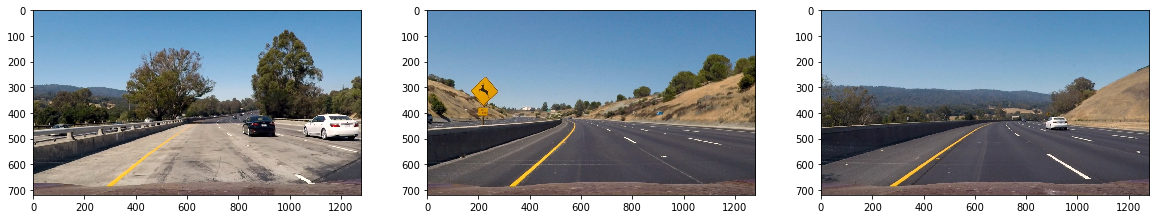

In [6]:
print_images(TEST_IMAGES, 'Test Images')

In [7]:
def get_image_size(image):
    return image.shape

In [8]:
(H, W, D) = get_image_size(TEST_IMAGES[0])

In [9]:
print('Image Dimensions: ' + str(W) + ' x ' + str(H))

Image Dimensions: 1280 x 720


In [10]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [11]:
def print_random_boxes(images):
    random_boxes = [
        ((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
        ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]

    drawn_images = [draw_boxes(image, random_boxes) for image in images]

    print_images(drawn_images, "Test Draw Boxes")

Test Draw Boxes
---------------


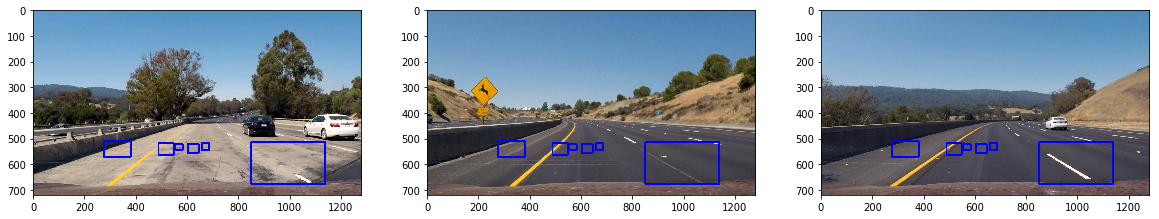

In [12]:
print_random_boxes(TEST_IMAGES)

In [13]:
def load_train_images():
    cars = []
    non_cars = []
    for image in glob.glob('train_images/vehicles/*/*'):
        cars.append(read_image(image))
    for image in glob.glob('train_images/non-vehicles/*/*'):
        non_cars.append(read_image(image))
    return cars, non_cars

In [14]:
CARS, NON_CARS = load_train_images()

Cars
----


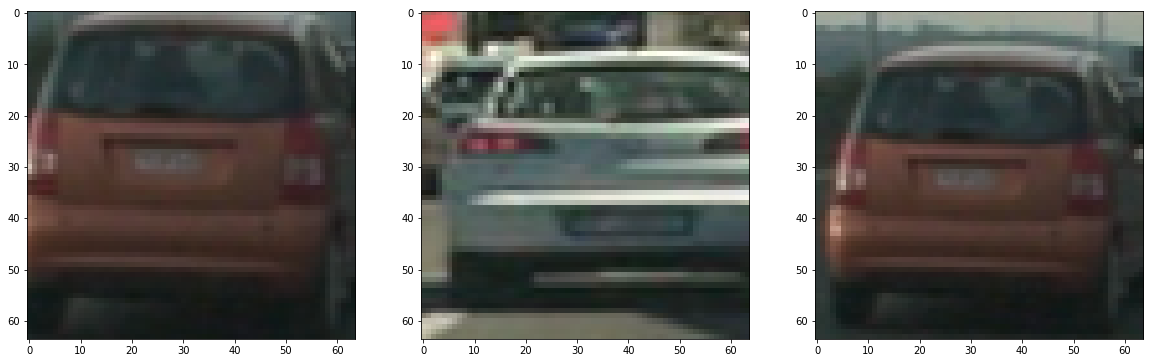

Non Cars
--------


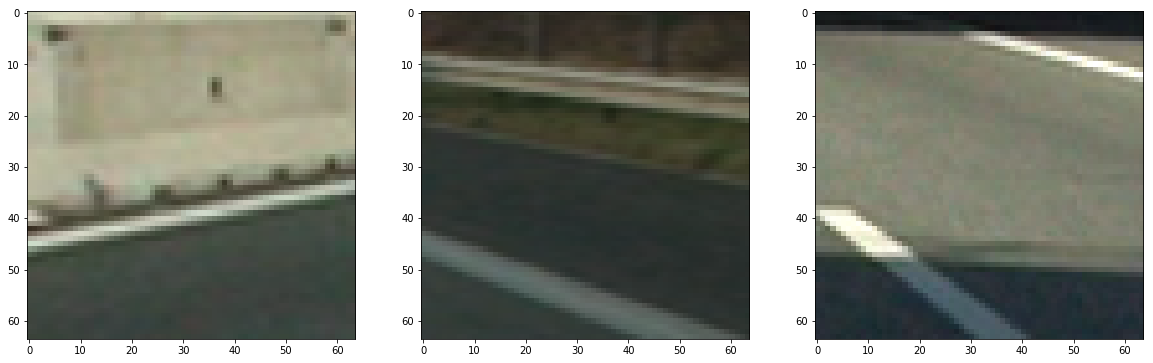

In [15]:
print_images(CARS[0:3], 'Cars')
print_images(NON_CARS[0:3], 'Non Cars')

In [16]:
def get_color_histogram(image, nbins=32, bins_range=(0, 256), vis=True):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    if vis:
        # Generating bin centers
        bin_edges = rhist[1]

        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    
    return hist_features

In [17]:
def print_color_histogram(image, title = None):
    plt.subplots(1, 3, figsize=(20,4))
    
    rh, gh, bh, bincen, feature_vec = get_color_histogram(image, nbins=32, bins_range=(0, 256))

    if title:
        print(title)
        print('-' * len(title))

    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')

Car Color Histogram
-------------------


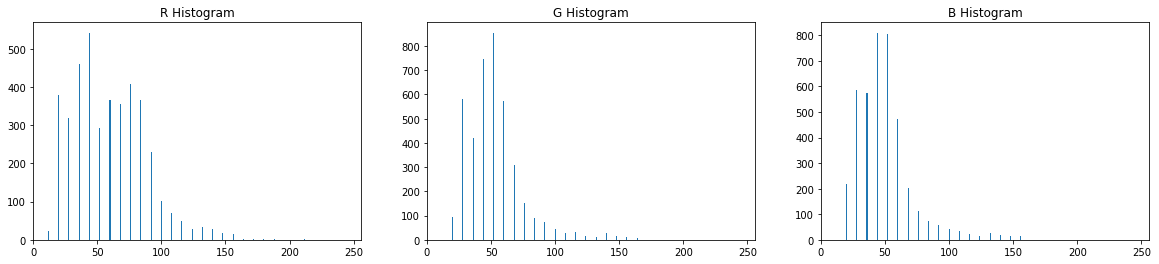

In [18]:
print_color_histogram(CARS[0], 'Car Color Histogram')

Non Car Color Histogram
-----------------------


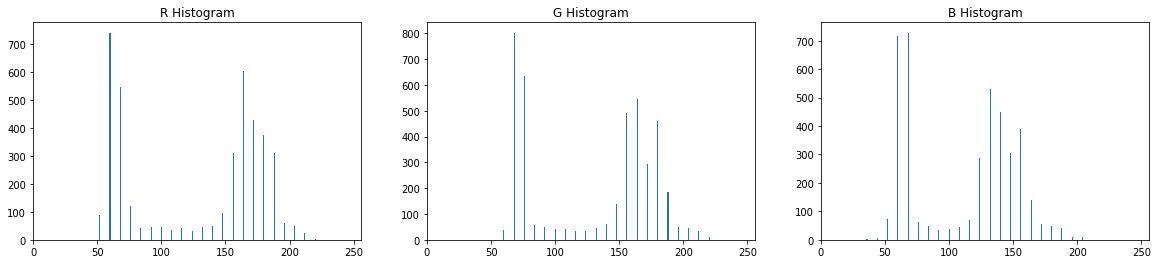

In [19]:
print_color_histogram(NON_CARS[0], 'Non Car Color Histogram')

In [20]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [21]:
def print_color_spaces(img, title = None):
    f, axs = plt.subplots(2, 3, figsize=(20, 10))
    color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    
    if title:
        print(title)
        print('-' * len(title))

    for i, color_space in enumerate(color_spaces):
        ax = axs[int(i / 3)][i % 3]
        ax.plot(bin_spatial(img, color_space))
        ax.set_title(color_space, fontsize=20)
    f.tight_layout() 

Car Color Spaces
----------------


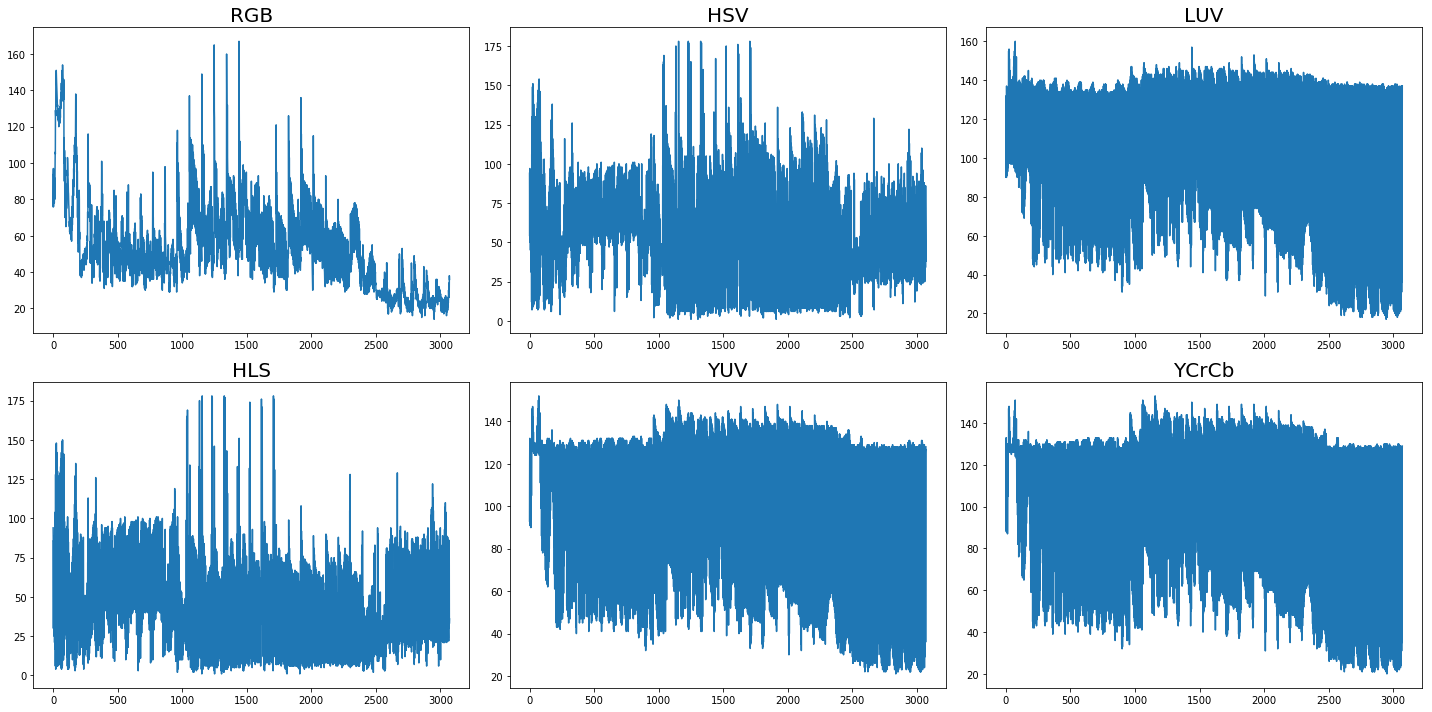

In [22]:
print_color_spaces(CARS[0], 'Car Color Spaces')

Non Car Color Spaces
--------------------


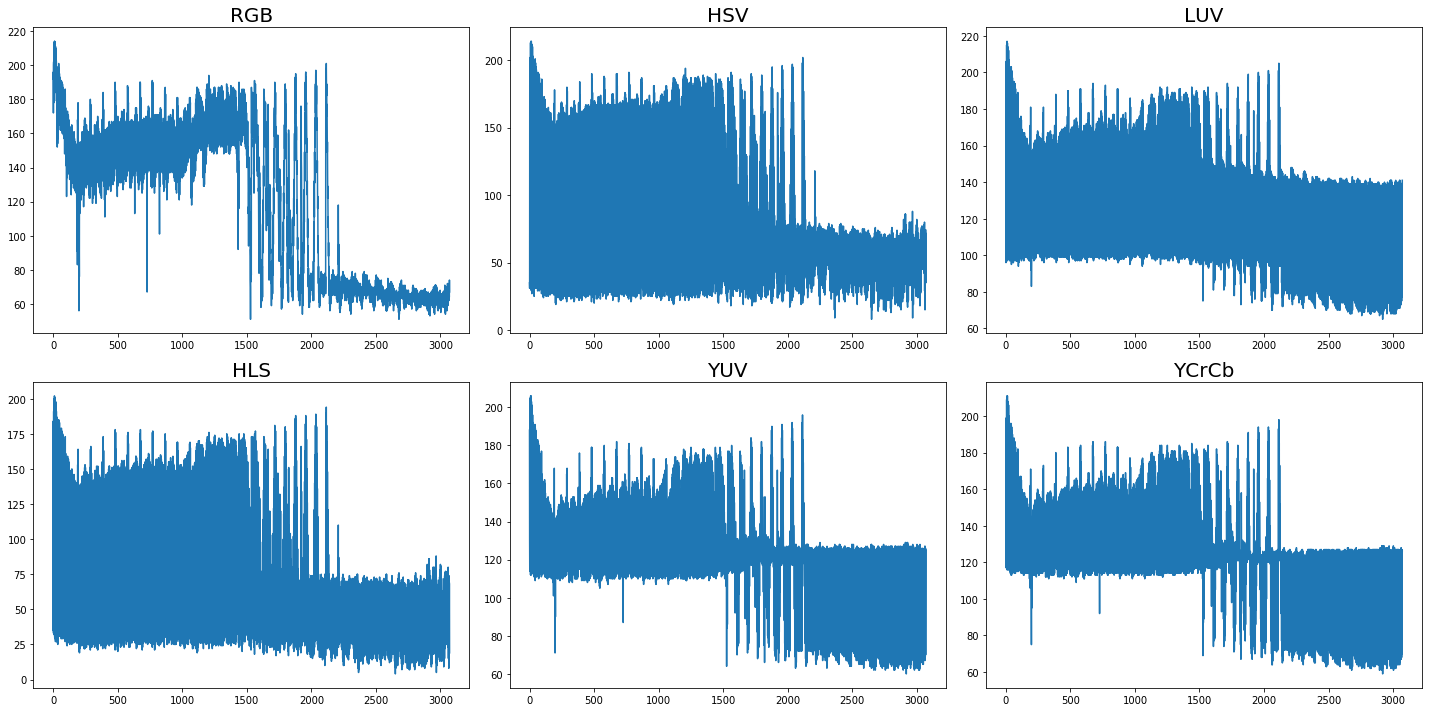

In [23]:
print_color_spaces(NON_CARS[0], 'Non Car Color Spaces')

In [24]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(image, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True, no_gray=False):
    if no_gray:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if vis == True:
        features, hog_image = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
            visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
           visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
    return features

In [25]:
def print_hog_features(image):
    features, hog_image = get_hog_features(image, vis=True)
    
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

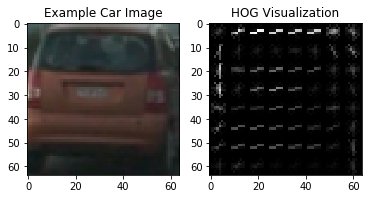

In [26]:
print_hog_features(CARS[0])

In [27]:
def single_img_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Read in each one by one
    # image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)      
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = get_color_histogram(feature_image, nbins=hist_bins, bins_range=hist_range, vis=False)
    # Append the new feature vector to the features list
    hog_features = get_hog_features(feature_image)
    # print(spatial_features, hist_features)
    return np.concatenate((spatial_features, hist_features, hog_features))

In [28]:
from sklearn.preprocessing import StandardScaler

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        features.append(single_img_features(image, cspace, spatial_size, hist_bins, hist_range))
    # Return list of feature vectors
    return features

In [29]:
CAR_FEATURES     = extract_features(CARS)
NON_CAR_FEATURES = extract_features(NON_CARS)

In [30]:
def get_scaled_features(car_features, notcar_features):
    # Create an array stack of feature vectors
    raw_X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(raw_X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(raw_X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    return raw_X, scaled_X, X_scaler, y

In [31]:
RAW_X, SCALED_X, X_SCALER, Y = get_scaled_features(CAR_FEATURES, NON_CAR_FEATURES)

In [32]:
def print_extracted_features(raw_X, scaled_X, car_images):
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(car_images[car_ind])
    plt.title('Original Image')
    plt.subplot(132)
    # print(X[0][car_ind])
    plt.plot(raw_X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

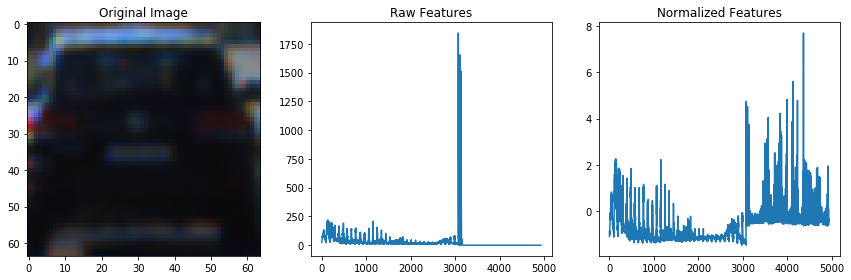

In [33]:
print_extracted_features(RAW_X, SCALED_X, CARS)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time

def train(scaled_X, y, spatial=32, histbin=32):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

In [35]:
SVC = train(SCALED_X, Y)

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4932
13.13 Seconds to train SVC...
Test Accuracy of SVC =  0.9778
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.00108 Seconds to predict 10 labels with SVC


In [36]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [37]:
def print_windows_small(image):
    windows = slide_window(image, xy_window=(90, 90), xy_overlap=(0.5, 0.5),
                           x_start_stop=[200, W-200], y_start_stop=[int(H/2), H-200])
    window_img = draw_boxes(image, windows, color=(0,0,255), thick=6)                    
    plt.imshow(window_img)

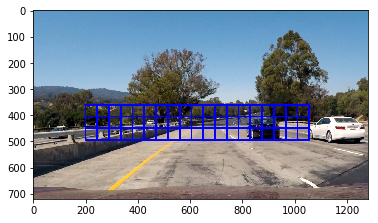

In [38]:
print_windows_small(TEST_IMAGES[0])

In [39]:
def print_windows_medium(image):
    windows = slide_window(image, xy_window=(120, 120), xy_overlap=(0.75, 0.75),
                           x_start_stop=[100, W-100], y_start_stop=[int(H/2), H-100])
    window_img = draw_boxes(image, windows, color=(255,0,0), thick=6)                    
    plt.imshow(window_img)

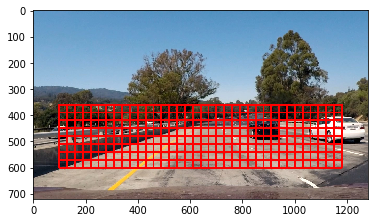

In [40]:
print_windows_medium(TEST_IMAGES[0])

In [41]:
def print_windows_large(image):
    windows = slide_window(image, xy_window=(180, 180), xy_overlap=(0.75, 0.75),
                           x_start_stop=[0, W], y_start_stop=[int(H/2), H])
    window_img = draw_boxes(image, windows, color=(0,255,0), thick=6)                    
    plt.imshow(window_img)

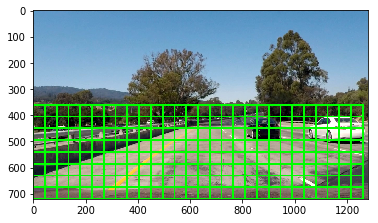

In [42]:
print_windows_large(TEST_IMAGES[0])

In [43]:
def search_windows(img, clf, scaler):
    windows = []
    
    windows.extend(slide_window(img, xy_window=(90, 90), xy_overlap=(0.5, 0.5),
                           x_start_stop=[200, W-200], y_start_stop=[int(H/2), H-200]))
    
    windows.extend(slide_window(img, xy_window=(120, 120), xy_overlap=(0.75, 0.75),
                           x_start_stop=[100, W-100], y_start_stop=[int(H/2), H-100]))
    
    windows.extend(slide_window(img, xy_window=(180, 180), xy_overlap=(0.75, 0.75),
                           x_start_stop=[0, W], y_start_stop=[int(H/2), H]))
    

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [44]:
def print_search_windows(img):
    windows = search_windows(img, SVC, X_SCALER)
    plt.imshow(draw_boxes(img, windows))

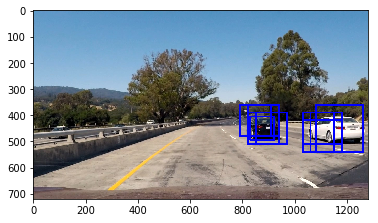

In [45]:
print_search_windows(TEST_IMAGES[0])

In [46]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [67]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=int(H/2), ystop=H, scale=1.5,
              svc=SVC, X_scaler=X_SCALER, orient=9, pix_per_cell=8, cell_per_block=2,
              spatial_size=(32,32), hist_bins=32):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, no_gray=True)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, no_gray=True)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, no_gray=True)
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # hog_features = get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=False, no_gray=True)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = get_color_histogram(subimg, nbins=hist_bins, vis=False)
            
            print(spatial_features.shape, hist_features.shape, hog_features.ravel().shape)
            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).astype(np.float64).reshape(1, -1))
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw draw_img= np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [68]:
out_img = find_cars(TEST_IMAGES[0])

plt.imshow(out_img)

(3072,) (96,) (5292,)


ValueError: operands could not be broadcast together with shapes (1,8460) (4932,) (1,8460) 